# TAYSIR competition - Track 2 Example Extraction

### Welcome!

This is a notebook to show the structure of a code to participate to the competition.

You can also check the baseline notebook (available in the same archive) for more details about the TAYSIR models and how to use them.

## Prepare your environment

In [1]:
import torch
import mlflow
print('PyTorch version :', torch.__version__)
print('MLflow version :', mlflow.__version__)
import sys
print("Your python version:", sys.version)

PyTorch version : 2.0.0+cpu
MLflow version : 2.2.2
Your python version: 3.9.1 (default, Dec 11 2020, 09:29:25) [MSC v.1916 64 bit (AMD64)]


In [2]:
torch.set_num_threads(4)

This notebook was tested with:
* Torch version: 1.11.0+cu102
* MLFlow version: 1.25.1
* Python version: 3.8.10 [GCC 9.4.0]

Python versions starting at 3.7 are supposed to work (but have not been tested).
## Choosing the phase

First you must select one of the phases/datasets we provide

In [5]:
TRACK = 2 #always for this track
DATASET = 1

In [6]:
model_name = f"models/{TRACK}.{DATASET}.taysir.model"
model = mlflow.pytorch.load_model(model_name)
model.eval()

2023/04/23 00:13:51 WARNING mlflow.pytorch: Stored model version '1.13.1+cpu' does not match installed PyTorch version '2.0.0+cpu'


TNetwork(
  23, 22, n_layers=2, neurons_per_layer=64, batch_size=64, patience=5, split_dense=True, task=lm
  (mach[0]): RNN(22, 64, batch_first=True)
  (mach[1]): RNN(64, 64, batch_first=True)
  (dense): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=22, bias=True)
    (2): Sigmoid()
    (3): Softmax(dim=-1)
  )
)

In [7]:
if not hasattr(model, 'distilbert'):#RNN
    nb_letters = model.input_size -1
    cell_type = model.cell_type

    print("The alphabet contains", nb_letters, "symbols.")
    print("The type of the recurrent cells is", cell_type.__name__)
else:
    nb_letters = model.distilbert.config.vocab_size
    print("The alphabet contains", nb_letters, "symbols.")
    print("The model is a transformer (DistilBertForSequenceClassification)")

The alphabet contains 22 symbols.
The type of the recurrent cells is RNN


## Load the data

The input data is in the following format :

```
[Number of sequences] [Alphabet size]
[Length of sequence] [List of symbols]
[Length of sequence] [List of symbols]
[Length of sequence] [List of symbols]
...
[Length of sequence] [List of symbols]
```

For example the following data :

```
5 10
6 8 6 5 1 6 7 4 9
12 8 6 9 4 6 8 2 1 0 6 5 9
7 8 9 4 3 0 4 9
4 8 0 4 9
8 8 1 5 2 6 0 5 3 9
```

is composed of 5 sequences and has an alphabet size of 10 (so symbols are between 0 and 9) and the first sequence is composed of 6 symbols (8 6 5 1 6 7 4 9), notice that 8 is the start symbol and 9 is the end symbol.

In [8]:
from pythautomata.base_types.alphabet import Alphabet

file = f"datasets/{TRACK}.{DATASET}.taysir.valid.words"

alphabet = None
sequences = []

#In the competition the empty sequence is defined as [alphabet_size - 2, alphabet size -1]
#For example with the alphabet of size 22 the empty sequence is [20, 21]
empty_sequence_len = 2

with open(file) as f:
    a = f.readline() #Skip first line (number of sequences, alphabet size)
    headline = a.split(' ')
    alphabet_size = int(headline[1].strip())
    alphabet = Alphabet.from_strings([str(x) for x in range(alphabet_size - 2)])
    
    for line in f:
        line = line.strip()
        seq = line.split(' ')
        seq = [int(i) for i in seq[1:]] #Remove first value (length of sequence) and cast to int
        sequences.append(seq)

In [9]:
print(alphabet)
print(len(alphabet))

frozenset({9, 10, 0, 15, 7, 8, 14, 3, 1, 4, 19, 13, 11, 16, 17, 6, 5, 12, 2, 18})
20


The variable *sequences* is thus **a list of lists**

In [10]:
print('Number of sequences:', len(sequences))
print('10 first sequences:')
for i in range(10):
    print(sequences[i])

Number of sequences: 9090
10 first sequences:
[20, 13, 14, 6, 0, 15, 4, 3, 5, 12, 13, 13, 14, 4, 12, 17, 21]
[20, 3, 13, 3, 16, 6, 4, 13, 1, 21]
[20, 13, 6, 15, 21]
[20, 13, 10, 3, 21]
[20, 13, 10, 3, 16, 6, 4, 13, 13, 12, 17, 4, 13, 14, 10, 0, 10, 13, 14, 4, 15, 12, 17, 21]
[20, 3, 5, 0, 1, 4, 13, 6, 14, 4, 14, 4, 14, 13, 10, 12, 1, 5, 10, 3, 14, 5, 12, 14, 1, 12, 11, 12, 17, 18, 8, 21]
[20, 3, 13, 3, 19, 1, 4, 3, 5, 10, 3, 19, 8, 21]
[20, 13, 0, 1, 3, 1, 13, 3, 16, 6, 4, 13, 1, 12, 8, 0, 5, 10, 14, 12, 10, 3, 14, 1, 21]
[20, 13, 14, 14, 6, 3, 21]
[20, 13, 12, 13, 3, 16, 3, 16, 21]


In [11]:
from collections import defaultdict
import numpy as np        
# Defining the dict
d = defaultdict(lambda: 0)
lengths_orig = []
for seq in sequences:
    lengths_orig.append(len(seq))
    d[len(seq)]+=1
    

In [12]:
np.mean(lengths_orig)

16.954565456545655

Number of sequences: 9090


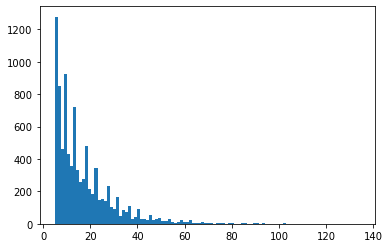

In [13]:
print('Number of sequences:', len(sequences))
import matplotlib.pyplot as plt
x = plt.hist(lengths_orig, bins = 100)

In [12]:
import utils
import random

def generate_seq(model, cache):
    dummy_seq = [len(alphabet)-1, len(alphabet)]
    next_probas = utils.full_next_symbols_probas(dummy_seq, model)[1]
    seq  = [len(alphabet)-1]    
    next_symbol = random.choices(list(range(len(alphabet)+3)), weights = next_probas, k = 1)
    seq.extend(next_symbol)    
    while next_symbol[0]!=len(alphabet)+2:
        if tuple(seq) in cache:
            next_probas = cache[tuple(seq)]
        else:
            next_probas = utils.next_symbols_probas(seq, model)
            cache[tuple(seq)] = next_probas
        next_symbol = random.choices(list(range(len(alphabet)+3)), weights = next_probas, k = 1)
        seq.extend(next_symbol)        
    return seq

In [13]:
cache = dict()

In [14]:
from tqdm import tqdm
new_valid_seqs = []
lengths = []
for i in tqdm(range(1000)):
    generated_seq = generate_seq(model, cache)
    new_valid_seqs.append(generated_seq)    
    lengths.append(len(generated_seq))    

 12%|█▎        | 125/1000 [04:03<28:25,  1.95s/it]  


KeyboardInterrupt: 

In [14]:
x = plt.hist(lengths, bins = 100)
np.mean(lengths)

NameError: name 'lengths' is not defined

## Model extraction

This is where you will extract your simple own model.

In [15]:
from pythautomata.model_comparators.wfa_partition_comparison_strategy import WFAPartitionComparator
from pythautomata.utilities.probability_partitioner import QuantizationProbabilityPartitioner
#from pythautomata.model_exporters.wfa_image_exporter_with_partition_mapper import WFAImageExporterWithPartitionMapper
from pythautomata.base_types.symbol import SymbolStr
from pythautomata.utilities.uniform_length_sequence_generator import UniformLengthSequenceGenerator

from pymodelextractor.learners.observation_tree_learners.bounded_pdfa_quantization_n_ary_tree_learner import BoundedPDFAQuantizationNAryTreeLearner
from pymodelextractor.teachers.pac_batch_probabilistic_teacher import PACBatchProbabilisticTeacher
from pymodelextractor.teachers.pac_probabilistic_teacher import PACProbabilisticTeacher
from pymodelextractor.utils.pickle_data_loader import PickleDataLoader

from utils import predict
from pytorch_language_model import PytorchLanguageModel

name = "track_" + str(TRACK) + "_dataset_" + str(DATASET)

target_model = PytorchLanguageModel(alphabet, model, name)


In [16]:
from pythautomata.base_types.alphabet import Alphabet
from pythautomata.base_types.symbol import SymbolStr
from pythautomata.base_types.sequence import Sequence

def get_alphabet_and_validation_sequences(ds):
    file = f"datasets/2.{ds}.taysir.valid.words"
    alphabet = None
    sequences = []

    empty_sequence_len = 2
    with open(file) as f:
        a = f.readline()
        headline = a.split(' ')
        alphabet_size = int(headline[1].strip())
        alphabet = Alphabet.from_strings([str(x) for x in range(alphabet_size - empty_sequence_len)])
        for line in f:
            line = line.strip()
            seq = line.split(' ')[1:]
            seq = [SymbolStr(i) for i in seq[1:]]            
            sequences.append(Sequence(seq))
    return alphabet, sequences

In [17]:
_, pythaut_sequences = get_alphabet_and_validation_sequences(DATASET)

In [18]:
suffixes = [target_model.terminal_symbol]
for symbol in target_model.alphabet.symbols:
    suffixes.append(Sequence((symbol,)))

In [19]:
seq_0 = Sequence([SymbolStr('0')])
seq_010 = Sequence([SymbolStr('0'), SymbolStr('1'), SymbolStr('0')])
seq_eps = Sequence([])

In [43]:
symbols = list(target_model.alphabet.symbols)
symbols.sort()
symbols = [target_model.terminal_symbol] + symbols
res = target_model.get_last_token_weights(seq_eps, symbols)
print(len(res))
print(np.sum(res))
res = list(zip(symbols, res))
res.sort(key=lambda x: int(x[0].value))
for i in res:
    print(i)

21
0.9213731437921524
(0, 0.0)
(1, 0.03931346535682678)
(2, 0.039313968271017075)
(3, 0.039313461631536484)
(4, 0.1068650633096695)
(5, 0.039313461631536484)
(6, 0.039313461631536484)
(7, 0.039313461631536484)
(8, 0.039313461631536484)
(9, 0.039313461631536484)
(10, 0.039313461631536484)
(11, 0.039313528686761856)
(12, 0.039313461631536484)
(13, 0.03931359201669693)
(14, 0.1068650633096695)
(15, 0.039313461631536484)
(16, 0.039313461631536484)
(17, 0.039313461631536484)
(18, 0.039313461631536484)
(19, 0.039313461631536484)
(21, 0.039313461631536484)


In [30]:
target_model.sequence_probability(seq_eps)

0.039313461631536484

In [32]:
import utils
utils.sequence_probability([20,21], model)

0.039313461631536484

In [42]:
a = utils.next_symbols_probas([20,20], model)
print(len(a))
print(np.sum(a))
res = list(zip(range(len(a)), a))
res.sort(key=lambda x: x[0])
for i in res:
    print(i)


23
0.9999999
(0, 0.0)
(1, 0.039313465)
(2, 0.03931397)
(3, 0.03931346)
(4, 0.10686506)
(5, 0.03931346)
(6, 0.03931346)
(7, 0.03931346)
(8, 0.03931346)
(9, 0.03931346)
(10, 0.03931346)
(11, 0.03931353)
(12, 0.03931346)
(13, 0.039313592)
(14, 0.10686506)
(15, 0.03931346)
(16, 0.03931346)
(17, 0.03931346)
(18, 0.03931346)
(19, 0.03931346)
(20, 0.03931346)
(21, 0.03931346)
(22, 0.03931346)


In [110]:
symbols

[21, 0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 3, 4, 5, 6, 7, 8, 9]

In [143]:
suffixes

[21, 9, 15, 17, 13, 19, 16, 11, 0, 5, 8, 10, 6, 7, 1, 12, 3, 2, 4, 14, 18]

In [144]:
target_model.get_last_token_weights_batch([seq_eps], suffixes)

[[0.03931346,
  0.03931346,
  0.03931346,
  0.03931346,
  0.039313592,
  0.03931346,
  0.03931346,
  0.03931353,
  0.0,
  0.03931346,
  0.03931346,
  0.03931346,
  0.03931346,
  0.03931346,
  0.039313465,
  0.03931346,
  0.03931346,
  0.03931397,
  0.10686506,
  0.10686506,
  0.03931346]]

In [113]:
#from last_token_weights_pickle_dataset_generator import LastTokenWeightsPickleDataSetGenerator
#LastTokenWeightsPickleDataSetGenerator().genearte_dataset(target_model, 1000, "./test",10)

In [141]:
#from pythautomata.automata.wheighted_automaton_definition.probabilistic_deterministic_finite_automaton import \
#    ProbabilisticDeterministicFiniteAutomaton as PDFA
#from pythautomata.automata.wheighted_automaton_definition.weighted_state import WeightedState
#from pythautomata.model_comparators.wfa_tolerance_comparison_strategy import WFAToleranceComparator

#weight = 1.0/(len(alphabet)+1)
#weight = 0
#q0 = WeightedState("q0", 1, weight)
#for symbol in alphabet.symbols:
#    q0.add_transition(symbol, q0, weight)
#states = {q0}
#comparator = WFAToleranceComparator()
#testPDFA = PDFA(alphabet, states, target_model.terminal_symbol, comparator, "Test", check_is_probabilistic = False)


In [142]:
#testPDFA.sequence_probability(seq_0)

0.0

In [209]:

from pymodelextractor.teachers.sample_batch_probabilistic_teacher import SampleBatchProbabilisticTeacher
epsilon = 0.1
delta = 0.1
max_states = 1000000
max_query_length= 1000000
max_secs = None
sequence_generator = UniformLengthSequenceGenerator(alphabet, max_seq_length=2, min_seq_length=2)
dataloader = PickleDataLoader("./data_caches/"+target_model.name) 

partitioner = QuantizationProbabilityPartitioner(1000)
comparator = WFAPartitionComparator(partitioner)
teacher1  = SampleBatchProbabilisticTeacher(model = target_model, comparator = comparator, sequence_generator=sequence_generator, max_seq_length=2, full_prefix_set=True,  cache_from_dataloader=dataloader)
learner = BoundedPDFAQuantizationNAryTreeLearner(partitioner, max_states, max_query_length, max_secs, generate_partial_hipothesis = True, pre_cache_queries_for_building_hipothesis = False,  check_probabilistic_hipothesis = False)
learning_result = learner.learn(teacher1)     

KeyboardInterrupt: 

In [148]:
len(learning_result.model.weighted_states)

50

In [149]:
learned_model = learning_result.model

In [211]:
learned_model.sequence_probability(seq_0)

0.0

In [212]:
target_model.sequence_probability(seq_0)

0.0012922859750688076

In [156]:
suffixes = list()
suffixes.append(Sequence() + learned_model.terminal_symbol)

for symbol in learned_model.alphabet.symbols:
    suffixes.append(Sequence((symbol,)))

In [170]:
max(np.array(learned_model.last_token_probabilities(seq_010, suffixes)) - np.array(target_model.last_token_probabilities(seq_010, suffixes)))
0.06757163628935814 < 1/10

True

In [193]:
learned_model.sequence_probability(seq_eps)

1.0

In [191]:
for state in learned_model.weighted_states:
    if len(state.name) <1:
        print(state.name)
        print("Terminal symbol prob:", state.final_weight)
        for symbol, weighted_transitions in state.transitions_list.items():
            print(symbol, weighted_transitions[0][1])

ϵ
Terminal symbol prob: 0.039313461631536484
0 0.0
1 0.03931346535682678
10 0.039313461631536484
11 0.039313528686761856
12 0.039313461631536484
13 0.03931359201669693
14 0.1068650633096695
15 0.039313461631536484
16 0.039313461631536484
17 0.039313461631536484
18 0.039313461631536484
19 0.039313461631536484
2 0.039313968271017075
3 0.039313461631536484
4 0.1068650633096695
5 0.039313461631536484
6 0.039313461631536484
7 0.039313461631536484
8 0.039313461631536484
9 0.039313461631536484


In [12]:
#teacher2  = PACBatchProbabilisticTeacher(target_model, epsilon = epsilon, delta = delta, max_seq_length = None, comparator = comparator, sequence_generator=sequence_generator, compute_epsilon_star=False, cache_from_dataloader=dataloader)
#learner2 = BoundedPDFAQuantizationNAryTreeLearner(partitioner, max_states, max_query_length, max_secs, generate_partial_hipothesis = False, pre_cache_queries_for_building_hipothesis = False,  check_probabilistic_hipothesis = False)
#learning_result = learner2.learn(teacher2)     

In [13]:
learning_result.model

## Save and submit 
This is the creation of the model needed for the submission to the competition: you just have to run this cell. It will create in your current directory an **archive** that you can then submit on the competition website.

**You should NOT modify this part, just run it**

In [194]:
from fast_pdfa_wrapper import MlflowFastPDFA
from submit_tools_fix import save_function
from fast_pdfa_converter import FastProbabilisticDeterministicFiniteAutomatonConverter as FastPDFAConverter

fast_pdfa = FastPDFAConverter().to_fast_pdfa(learning_result.model)
mlflow_fast_pdfa = MlflowFastPDFA(fast_pdfa)
#save_function(mlflow_fast_pdfa, len(learning_result.model.alphabet), target_model.name)

In [208]:
fast_pdfa.sequence_probability([1,2,1])

5.937393605485925e-05

In [143]:
from fast_pdfa_wrapper import MlflowFastPDFA
from submit_tools_fix import save_function
from fast_pdfa_converter import FastProbabilisticDeterministicFiniteAutomatonConverter as FastPDFAConverter

fast_pdfa = FastPDFAConverter().to_fast_pdfa(testPDFA)
mlflow_fast_pdfa = MlflowFastPDFA(fast_pdfa)
save_function(mlflow_fast_pdfa, len(testPDFA.alphabet), "TEST_PDFA_0")

Submission created at predicted_models/TEST_PDFA_0.zip.


In [97]:
save_function(mlflow_fast_pdfa, len(testPDFA.alphabet), "TEST_PDFA")

Submission created at predicted_models/TEST_PDFA.zip.


In [98]:
#zip_path = f"predicted_models/{target_model.name}.zip"
zip_path = f"predicted_models/TEST_PDFA.zip"
from load_func import load_function
print(sequences[0:10])
load_function(zip_path, sequences[0:10])

[[20, 19, 8, 18, 7, 19, 11, 3, 18, 11, 2, 16, 7, 9, 8, 6, 15, 7, 9, 16, 2, 8, 15, 6, 13, 14, 19, 8, 8, 7, 15, 3, 9, 6, 10, 6, 17, 15, 21], [20, 7, 13, 12, 6, 8, 13, 9, 8, 3, 16, 7, 12, 13, 14, 7, 7, 13, 16, 15, 9, 13, 19, 19, 7, 2, 4, 2, 15, 15, 12, 8, 7, 11, 7, 17, 15, 21], [20, 11, 13, 19, 18, 11, 9, 13, 11, 4, 7, 10, 2, 14, 9, 6, 2, 2, 19, 1, 12, 3, 11, 10, 6, 3, 2, 3, 2, 5, 15, 11, 8, 7, 18, 14, 17, 15, 21], [20, 3, 9, 19, 10, 19, 6, 5, 2, 11, 1, 12, 7, 17, 4, 7, 15, 17, 14, 2, 18, 12, 18, 6, 13, 4, 2, 10, 15, 15, 3, 8, 7, 1, 14, 21], [20, 2, 11, 2, 19, 2, 13, 9, 9, 12, 3, 4, 12, 8, 7, 13, 17, 13, 16, 10, 11, 1, 6, 6, 19, 3, 2, 15, 5, 8, 15, 19, 3, 11, 11, 6, 7, 6, 13, 2, 3, 3, 4, 15, 12, 6, 7, 11, 14, 17, 21], [20, 18, 16, 6, 5, 0, 19, 2, 13, 9, 11, 3, 8, 14, 12, 9, 14, 13, 14, 2, 2, 15, 3, 18, 10, 13, 13, 8, 13, 3, 12, 15, 18, 8, 7, 11, 7, 19, 15, 21], [20, 1, 5, 14, 5, 7, 19, 12, 3, 5, 14, 11, 3, 14, 2, 2, 7, 1, 10, 2, 16, 19, 7, 14, 11, 12, 2, 14, 3, 12, 2, 12, 7, 14, 4, 2, 3, 